In [1]:
import pandas as pd
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [3]:
#hide
from fastbook import *
from fastai.vision.widgets import *

## Gathering Data

# clean
To download images with Bing Image Search, sign up at [Microsoft Azure](https://azure.microsoft.com/en-us/services/cognitive-services/bing-web-search-api/) for a free account. You will be given a key, which you can copy and enter in a cell as follows (replacing 'XXX' with your key and executing it):

In [4]:
key = os.environ.get('AZURE_SEARCH_KEY', '7e411e7eec814c6ea5e3331cf9654eac')

In [5]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [6]:
results = search_images_bing(key, 'owl')
ims = results.attrgot('contentUrl')
len(ims) , ims[0]

(150,
 'http://upload.wikimedia.org/wikipedia/commons/b/b2/Bengalese_Eagle_Owl.jpg')

In [7]:
#hide
ims = ['https://i.natgeofe.com/k/50fe4ce2-3d74-4da8-984d-887b7fb75005/GreatHornedOwl1_3x4.jpg']

In [8]:
dest = 'images/owl.jpg'
download_url(ims[0], dest)

Path('images/owl.jpg')

In [9]:
birds_types = 'owl','swift','eagle'
path = Path('birds')

In [10]:
if not path.exists():
    path.mkdir()
    for o in birds_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bird')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [11]:
fns = get_image_files(path)
fns

(#412) [Path('birds/owl/bce24719-0be2-4d78-aafd-d91db79cf26a.jpg'),Path('birds/owl/f21702b1-b742-4cd3-864b-647447a64f34.jpg'),Path('birds/owl/2a455d51-a95e-4a10-bbcf-619d72facf65.jpg'),Path('birds/owl/c1160b93-c97f-43c1-9f28-f6f41283c663.jpg'),Path('birds/owl/62ee69d3-8a4a-4cda-9444-b5c2b37c61e7.jpg'),Path('birds/owl/8d53530c-c12d-42bd-afdf-8e892c39e9f6.jpg'),Path('birds/owl/a8b8b978-d897-4f15-b1fe-d2e3e611164f.jpg'),Path('birds/owl/cc0fa90f-c9ff-4f77-93f6-0b5d8371128c.jpg'),Path('birds/owl/a1b88d58-8e01-45c7-a2f7-26631495b4f1.jpg'),Path('birds/owl/3e8a61b1-894d-4987-b58e-8f621ede089e.jpg')...]

In [12]:
failed = verify_images(fns)
failed

(#0) []

In [13]:
failed.map(Path.unlink);

### Sidebar: Getting Help in Jupyter Notebooks

### End sidebar

## From Data to DataLoaders

In [14]:
birds = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [15]:
dls = birds.dataloaders(path)

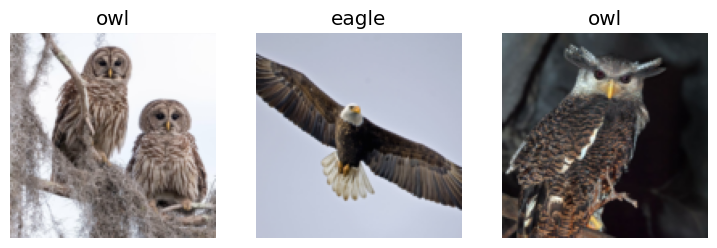

In [16]:
dls.valid.show_batch(max_n=3, nrows=1)

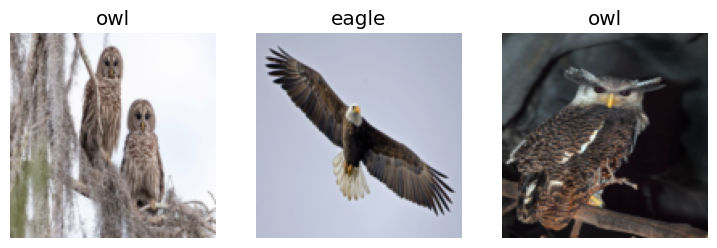

In [17]:
birds = birds.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = birds.dataloaders(path)
dls.valid.show_batch(max_n=3, nrows=1)

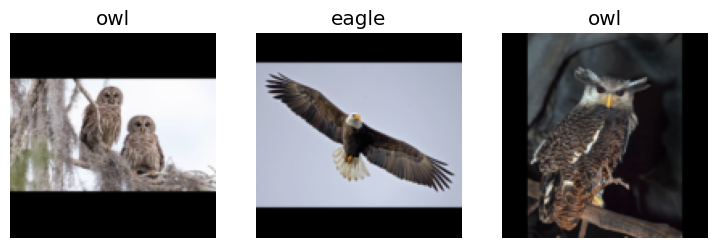

In [18]:
birds = birds.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = birds.dataloaders(path)
dls.valid.show_batch(max_n=3, nrows=1)

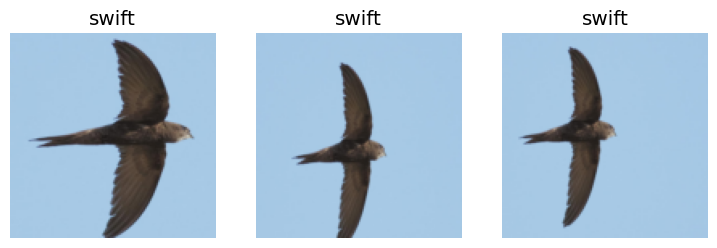

In [19]:
birds = birds.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = birds.dataloaders(path)
dls.train.show_batch(max_n=3, nrows=1, unique=True)

### Data Augmentation

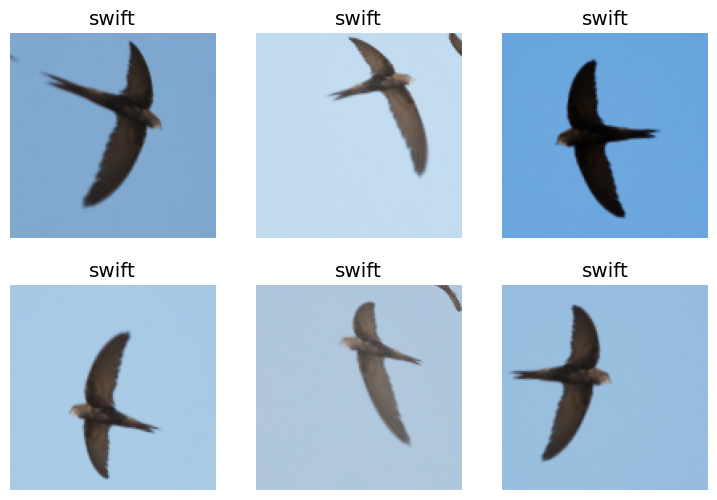

In [20]:
birds = birds.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = birds.dataloaders(path)
dls.train.show_batch(max_n=6, nrows=2, unique=True)

## Training Your Model, and Using It to Clean Your Data

In [21]:
birds = birds.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = birds.dataloaders(path)

In [22]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.472288,0.210999,0.085366,00:27


epoch,train_loss,valid_loss,error_rate,time
0,0.362922,0.092599,0.024390,00:27
1,0.240234,0.028950,0.000000,00:29
2,0.179690,0.012365,0.000000,00:29
3,0.139775,0.012678,0.000000,00:26


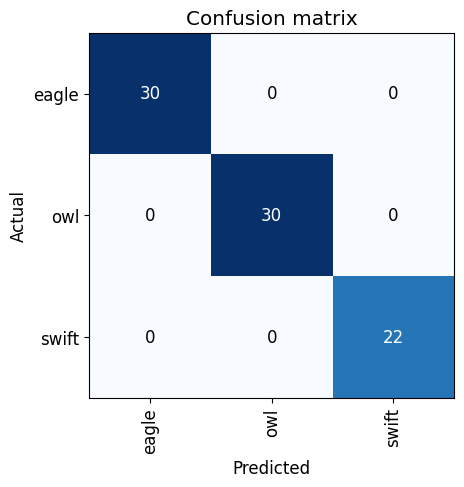

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

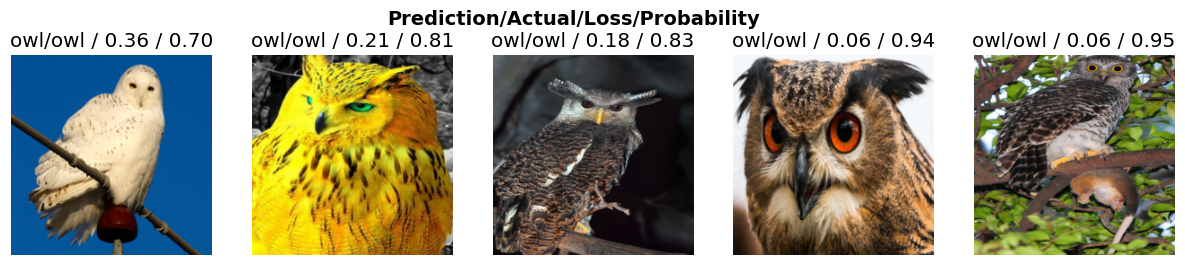

In [24]:
interp.plot_top_losses(5, nrows=1)

In [25]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [26]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Turning Your Model into an Online Application

### Using the Model for Inference

In [27]:
learn.export()

In [28]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [29]:
learn_inf = load_learner(path/'export.pkl')

In [30]:
learn_inf.dls.vocab

['eagle', 'owl', 'swift']

### Creating a Notebook App from the Model

In [42]:
btn_upload = widgets.FileUpload()

In [32]:
out_pl = widgets.Output()


In [33]:
lbl_pred = widgets.Label()

In [43]:
btn_run = widgets.Button(description='Classify')

In [35]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [36]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [37]:
VBox([widgets.Label('Select your birds!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

### Turning Your Notebook into a Real App

In [38]:
#hide
!pip install voila
!jupyter serverextension enable --sys-prefix voila 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Enabling: voila
- Writing config: /usr/etc/jupyter
    - Validating...
      voila 0.4.0 OK


In [39]:
! pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
! pip install voila

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
! pip install watermark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
%load_ext watermark

%watermark -v -m -p wget,voila,fastbook,numpy,pandas,geopy,altair,vega_datasets,watermark

print(" ")
%watermark -u -n -t -z

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 7.34.0

wget         : 3.2
voila        : 0.4.0
fastbook     : 0.0.29
numpy        : 1.22.4
pandas       : 1.5.3
geopy        : 2.3.0
altair       : 4.2.2
vega_datasets: 0.9.0
watermark    : 2.3.1

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 5.10.147+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

 
Last updated: Thu Apr 20 2023 23:55:33UTC



In [45]:
learn.export(os.path.abspath('./export.pkl'))